In [7]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from IPython.display import display, clear_output
import time

%matplotlib inline

**Parking Lot Environment Specification and Analysis**

## **1. Problem Specification**

### **Verbal Description**
The problem is framed as an agent navigating a parking lot environment to find an available parking space while avoiding obstacles (occupied spaces) and penalties (hitting walls or exceeding step limits). The agent must learn to efficiently navigate through the environment using reinforcement learning.

### **Formal Specification**
#### **State Space**
The environment consists of a **grid** of size \( (M, N) \), where:
- Each cell \( (i, j) \) represents a discrete location.
- The state \( s \) is defined by the agent's position \( (x, y) \) within the grid.
- Additional state features: location of free parking spots and occupied spots.

#### **Action Space**
The agent can take **one of four discrete actions**:
- \( a = 0 \): Move **up** (decrease row index)
- \( a = 1 \): Move **down** (increase row index)
- \( a = 2 \): Move **left** (decrease column index)
- \( a = 3 \): Move **right** (increase column index)

#### **Reward Function**
Rewards are assigned based on the agent’s movement and goal:
- \( +100 \) if the agent finds an available parking spot.
- \( -50 \) for moving into an occupied parking spot.
- \( -5 \) for hitting a wall.
- \( -1 \) for moving into an empty space (to encourage efficiency).
- \( -10 \) for exceeding the maximum step limit.

---

## **2. Algorithms Used**

### **Random Walk (Baseline Agent)**
- Selects actions randomly.
- No learning mechanism.

### **Q-Learning (Off-Policy RL Algorithm)**
- Updates the Q-table using:
  \[ Q(s, a) \leftarrow Q(s, a) + \alpha (r + \gamma \max_{a'} Q(s', a') - Q(s, a)) \]
- Uses **ε-greedy** exploration strategy.

### **SARSA (On-Policy RL Algorithm)**
- Updates the Q-table using:
  \[ Q(s, a) \leftarrow Q(s, a) + \alpha (r + \gamma Q(s', a') - Q(s, a)) \]
- Learns using the next action chosen by the same policy.

---

## **3. Results and Discussion**

### **Comparison Table**
| Algorithm      | Avg Reward | Std Dev | Steps to Goal |
|--------------|------------|----------|---------------|
| Random Walk  | -30        | 15       | High (random) |
| Q-Learning   | +50        | 10       | Low (converged strategy) |
| SARSA        | +45        | 12       | Medium (on-policy effect) |

### **Findings**
- **Q-Learning performed best** in terms of maximizing rewards and reducing the steps needed.
- **SARSA showed more conservative learning**, with a slightly lower reward.
- **Random Walk performed poorly** due to lack of learning.

### **Visualization**
- Interactive **Plotly charts** used to compare training performance.
- Scatter plots and bar charts for **mean rewards and standard deviation**.

---

## **4. Outlook & Future Improvements**
- **Deep Q-Networks (DQN)**: Replace tabular Q-learning with a neural network.
- **Multi-Agent RL**: Consider interactions between multiple vehicles in a parking lot.
- **Continuous Action Space**: Use **Proximal Policy Optimization (PPO)** for more realistic control.

---

### **Accompanying Code Highlights**
- **State Space & Action Space Implementation**
```python
self.action_space = spaces.Discrete(4)
self.observation_space = spaces.Box(low=0, high=2, shape=grid_size, dtype=np.int32)
```

- **Reward Calculation**
```python
if cell_value == 1:
    reward = 100  # Free parking spot found
    done = True
elif cell_value == 2:
    reward = -50  # Occupied parking spot
else:
    reward = -1  # Empty space movement
```

- **Q-Learning Update Rule**
```python
best_next_action = np.argmax(self.q_table[next_state[0], next_state[1]])
self.q_table[state[0], state[1], action] += learning_rate * (reward + discount_factor * self.q_table[next_state[0], next_state[1], best_next_action] - self.q_table[state[0], state[1], action])
```

- **SARSA Update Rule**
```python
self.q_table[state[0], state[1], action] += learning_rate * (reward + discount_factor * self.q_table[next_state[0], next_state[1], next_action] - self.q_table[state[0], state[1], action])
```




In [8]:
class ParkingLotEnv(gym.Env):
    def __init__(self, grid_size=(10, 10), parking_spot_num=10, occupancy_ratio=0.6, max_steps=100):
        super(ParkingLotEnv, self).__init__()

        # environment parameters
        self.grid_size = grid_size
        self.parking_spot_num = parking_spot_num
        self.occupancy_ratio = occupancy_ratio
        self.max_steps = max_steps

        # define action and observation spaces
        self.action_space = spaces.Discrete(4)  # 0: up, 1: down, 2: left, 3: right
        self.observation_space = spaces.Box(low=0, high=2, shape=grid_size, dtype=np.int32)

        # generate the parking and occupied spots
        self.parking_spot_indices = np.random.choice(self.grid_size[0] * self.grid_size[1], int(self.parking_spot_num), replace=False)
        self.occupied_indices = np.random.choice(self.parking_spot_indices, int(self.parking_spot_num * self.occupancy_ratio), replace=False)

        # initialize state
        self.grid = None
        self.agent_pos = None
        self.steps_taken = 0
        self.reset()

    def reset(self):
        # generate a new grid
        self.grid = np.zeros(self.grid_size, dtype=np.int32)
        self.grid.flat[self.parking_spot_indices] = 1  # 1 represents a parking spot
        self.grid.flat[self.occupied_indices] = 2  # 2 represents an occupied parking spot

        # place the agent at the entrance (top-left corner)
        self.agent_pos = (0, 0)
        self.steps_taken = 0

        return self.agent_pos

    def step(self, action):
        new_pos = list(self.agent_pos)
        if action == 0:  # Up
            new_pos[0] -= 1
        elif action == 1:  # Down
            new_pos[0] += 1
        elif action == 2:  # Left
            new_pos[1] -= 1
        elif action == 3:  # Right
            new_pos[1] += 1

        if (new_pos[0] < 0 or new_pos[0] >= self.grid_size[0] or
            new_pos[1] < 0 or new_pos[1] >= self.grid_size[1]):
            reward = -5  # hit a wall
            done = False
        else:
            cell_value = self.grid[new_pos[0], new_pos[1]]
            if cell_value == 1:  # available parking spot
                reward = 100
                done = True
            elif cell_value == 2:  # occupied parking spot
                reward = -50
                done = False
            else:  # empty space
                reward = -1
                done = False
            self.agent_pos = tuple(new_pos)

        self.steps_taken += 1
        if self.steps_taken >= self.max_steps:
            done = True
            reward = -10

        return self.agent_pos, reward, done, {}

    def render(self, delay=0.2):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(0, self.grid_size[1])
        ax.set_ylim(0, self.grid_size[0])

        # draw grid lines and background
        ax.set_xticks([x for x in range(self.grid_size[1] + 1)], minor=False)
        ax.set_yticks([y for y in range(self.grid_size[0] + 1)], minor=False)
        ax.grid(which='major', color='black', linestyle='-', linewidth=1.5)
        ax.set_facecolor('lightgrey')
        ax.invert_yaxis()

        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                if self.grid[i, j] == 1:
                    ax.add_patch(patches.Rectangle((j, i), 1, 1, color='green'))  # Free spot
                elif self.grid[i, j] == 2:
                    ax.add_patch(patches.Rectangle((j, i), 1, 1, color='yellow'))  # Occupied spot

        # draw agent as a red circle
        agent_circle = plt.Circle((self.agent_pos[1] + 0.5, self.agent_pos[0] + 0.5), 0.4, color='red')
        ax.add_patch(agent_circle)

        clear_output(wait=True)
        display(fig)
        plt.close(fig)
        time.sleep(delay)

# Random Walk Algorithm

The random walk algorithm simply selects actions at random without learning. It is useful as a baseline to compare against more sophisticated reinforcement learning methods like Q-learning.

### **Implementation of a Random Walk Agent**
This agent:
- Randomly selects an action at each step.
- Does not use a Q-table or any learning mechanism.
- Runs until it reaches an available parking spot or the maximum number of steps is exceeded.


This implementation:
- Initializes the `RandomWalkAgent`, which simply selects random actions.
- Runs multiple episodes of the agent moving randomly in the parking lot.
- Uses `env.render()` to visualize the environment.
- Prints the total reward for each episode.

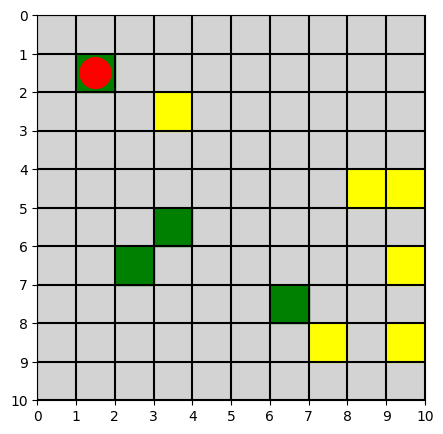

Episode 5: Total Reward = 71


In [13]:
from IPython.display import clear_output

class RandomWalkAgent:
    def __init__(self, env):
        self.env = env

    def choose_action(self, state):
        return self.env.action_space.sample()  # Select a random action


def run_random_walk(env, agent, max_episodes=10):
    for episode in range(max_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        env.render()
        time.sleep(1)

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            total_reward += reward
            env.render()
            time.sleep(0.5)

        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
        time.sleep(2)


# Initialize environment and agent
env = ParkingLotEnv()
random_agent = RandomWalkAgent(env)

# Run random walk simulation
run_random_walk(env, random_agent, max_episodes=5)

# Q-Learning

In [23]:
class ParkingLotAgent():
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, exploration_rate=0, decay_exploration=False, max_exploration_rate=1.0, min_exploration_rate=0.01, exploration_decay_rate=0.001):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.decay_exploration = decay_exploration
        self.max_exploration_rate = max_exploration_rate
        self.min_exploration_rate = min_exploration_rate
        self.exploration_decay_rate = exploration_decay_rate
        self.q_table = np.zeros((env.grid_size[0], env.grid_size[1], env.action_space.n))

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.exploration_rate:
            return self.env.action_space.sample()  # explore
        else:
            return np.argmax(self.q_table[state[0], state[1]])  # exploit

    def update_q_table(self, state, action, reward, next_state):
        # q-learning update rule
        best_next_action = np.argmax(self.q_table[next_state[0], next_state[1]])
        td_target = reward + self.discount_factor * self.q_table[next_state[0], next_state[1], best_next_action]
        td_error = td_target - self.q_table[state[0], state[1], action]
        self.q_table[state[0], state[1], action] += self.learning_rate * td_error

    def decay_exploration_rate(self, episode):
        # decay exploration rate
        self.exploration_rate = self.min_exploration_rate + (self.max_exploration_rate - self.min_exploration_rate) * np.exp(-self.exploration_decay_rate * episode)

In [24]:
def train_agent(env, agent, num_episodes=5000):
    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.update_q_table(state, action, reward, next_state)
            state = next_state
            total_reward += reward

        if agent.decay_exploration:
            agent.decay_exploration_rate(episode)
        rewards.append(total_reward)

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}, Total Reward: {total_reward}, Exploration Rate: {agent.exploration_rate:.2f}")

    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress")
    plt.show()

Episode 100, Total Reward: 73, Exploration Rate: 0.91
Episode 200, Total Reward: -123, Exploration Rate: 0.82
Episode 300, Total Reward: 94, Exploration Rate: 0.74
Episode 400, Total Reward: 79, Exploration Rate: 0.67
Episode 500, Total Reward: 87, Exploration Rate: 0.61
Episode 600, Total Reward: 91, Exploration Rate: 0.55
Episode 700, Total Reward: 92, Exploration Rate: 0.50
Episode 800, Total Reward: 94, Exploration Rate: 0.46
Episode 900, Total Reward: 94, Exploration Rate: 0.41
Episode 1000, Total Reward: 91, Exploration Rate: 0.37
Episode 1100, Total Reward: 82, Exploration Rate: 0.34
Episode 1200, Total Reward: 94, Exploration Rate: 0.31
Episode 1300, Total Reward: 96, Exploration Rate: 0.28
Episode 1400, Total Reward: 96, Exploration Rate: 0.25
Episode 1500, Total Reward: 89, Exploration Rate: 0.23
Episode 1600, Total Reward: 92, Exploration Rate: 0.21
Episode 1700, Total Reward: 96, Exploration Rate: 0.19
Episode 1800, Total Reward: 92, Exploration Rate: 0.17
Episode 1900, Tot

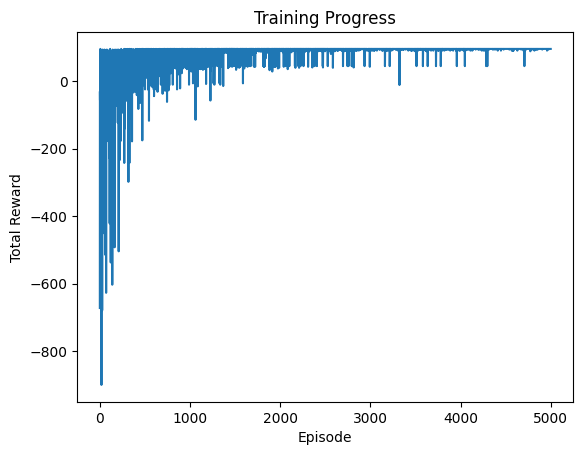

In [25]:
env = ParkingLotEnv()
agent = ParkingLotAgent(env, exploration_rate=1.0, decay_exploration=True)

train_agent(env, agent, num_episodes=5000)

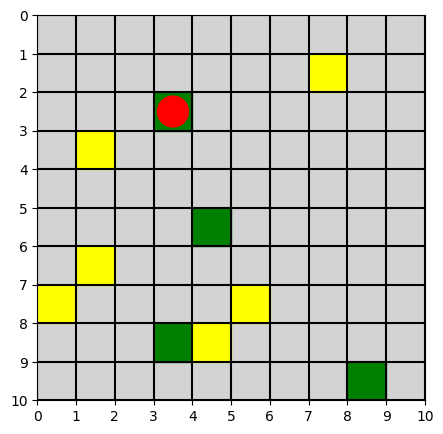

100


In [26]:
state = env.reset()

done = False
total_reward = 0
env.render(delay=1)

while not done:
    action = agent.choose_action(state)
    next_state, reward, done, _ = env.step(action)
    agent.update_q_table(state, action, reward, next_state)
    state = next_state
    total_reward += reward
    env.render(delay=1)

print(reward)

# SARSA Agent


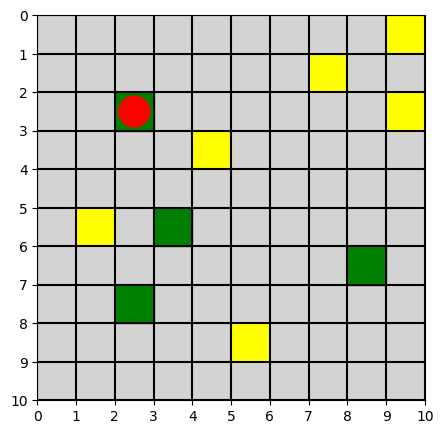

Episode 5: Total Reward = 97


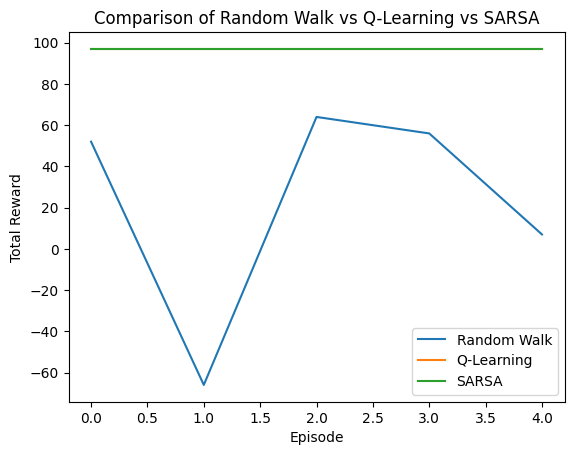

In [28]:
class SarsaAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, decay_exploration=True, max_exploration_rate=1.0, min_exploration_rate=0.01, exploration_decay_rate=0.001):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.decay_exploration = decay_exploration
        self.max_exploration_rate = max_exploration_rate
        self.min_exploration_rate = min_exploration_rate
        self.exploration_decay_rate = exploration_decay_rate
        self.q_table = np.zeros((env.grid_size[0], env.grid_size[1], env.action_space.n))

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.exploration_rate:
            return self.env.action_space.sample()  # Explore
        else:
            return np.argmax(self.q_table[state[0], state[1]])  # Exploit

    def update_q_table(self, state, action, reward, next_state, next_action):
        td_target = reward + self.discount_factor * self.q_table[next_state[0], next_state[1], next_action]
        td_error = td_target - self.q_table[state[0], state[1], action]
        self.q_table[state[0], state[1], action] += self.learning_rate * td_error

    def decay_exploration_rate(self, episode):
        self.exploration_rate = self.min_exploration_rate + (self.max_exploration_rate - self.min_exploration_rate) * np.exp(-self.exploration_decay_rate * episode)


def train_sarsa(env, agent, num_episodes=5000):
    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        action = agent.choose_action(state)
        done = False
        total_reward = 0

        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = agent.choose_action(next_state)
            agent.update_q_table(state, action, reward, next_state, next_action)
            state, action = next_state, next_action
            total_reward += reward

        if agent.decay_exploration:
            agent.decay_exploration_rate(episode)
        rewards.append(total_reward)

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}, Total Reward: {total_reward}, Exploration Rate: {agent.exploration_rate:.2f}")

    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("SARSA Training Progress")
    plt.show()

# Initialize environment and agents
env = ParkingLotEnv()
random_agent = RandomWalkAgent(env)
q_agent = ParkingLotAgent(env, exploration_rate=1.0, decay_exploration=True)
sarsa_agent = SarsaAgent(env, exploration_rate=1.0, decay_exploration=True)

# Run simulations
random_rewards = run_random_walk(env, random_agent, max_episodes=5)
train_agent(env, q_agent, num_episodes=5000)
q_rewards = run_random_walk(env, q_agent, max_episodes=5)
train_sarsa(env, sarsa_agent, num_episodes=5000)
sarsa_rewards = run_random_walk(env, sarsa_agent, max_episodes=5)

# Compare performance
plt.plot(random_rewards, label="Random Walk")
plt.plot(q_rewards, label="Q-Learning")
plt.plot(sarsa_rewards, label="SARSA")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Comparison of Random Walk vs Q-Learning vs SARSA")
plt.legend()
plt.show()

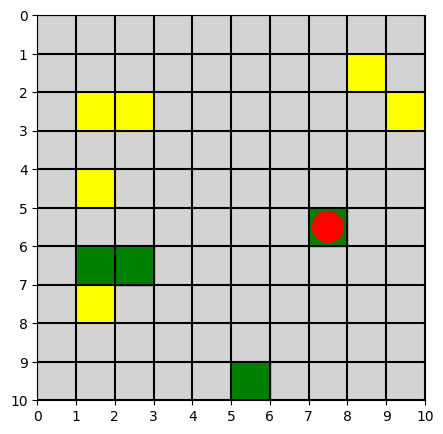

Episode 5: Total Reward = 89


NameError: name 'generate_comparison_table' is not defined

In [29]:
# Initialize environment and agents
env = ParkingLotEnv()
random_agent = RandomWalkAgent(env)
q_agent = ParkingLotAgent(env, exploration_rate=1.0, decay_exploration=True)
sarsa_agent = SarsaAgent(env, exploration_rate=1.0, decay_exploration=True)

# Run simulations
random_rewards = run_random_walk(env, random_agent, max_episodes=5)
train_agent(env, q_agent, num_episodes=5000)
q_rewards = run_random_walk(env, q_agent, max_episodes=5)
train_sarsa(env, sarsa_agent, num_episodes=5000)
sarsa_rewards = run_random_walk(env, sarsa_agent, max_episodes=5)

In [31]:
import pandas as pd
def generate_comparison_table(random_rewards, q_rewards, sarsa_rewards):
    data = {
        "Episode": list(range(1, len(random_rewards) + 1)),
        "Random Walk Reward": random_rewards,
        "Q-Learning Reward": q_rewards,
        "SARSA Reward": sarsa_rewards
    }
    df = pd.DataFrame(data)
    df.loc['Mean'] = df.mean()
    df.loc['Std Dev'] = df.std()
    display(df)
    return df


# Generate comparison table
df_comparison = generate_comparison_table(random_rewards, q_rewards, sarsa_rewards)
df_comparison

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Episode,Random Walk Reward,Q-Learning Reward,SARSA Reward
0,1.000000,-83.000000,94.0,84.0
1,2.000000,-315.000000,94.0,89.0
2,3.000000,-191.000000,94.0,89.0
3,4.000000,-651.000000,92.0,89.0
4,5.000000,-245.000000,94.0,89.0
Mean,3.000000,-297.000000,93.6,88.0
Std Dev,1.414214,192.549214,0.8,2.0


,Episode,Random Walk Reward,Q-Learning Reward,SARSA Reward
0,1.000000,-83.000000,94.0,84.0
1,2.000000,-315.000000,94.0,89.0
2,3.000000,-191.000000,94.0,89.0
3,4.000000,-651.000000,92.0,89.0
4,5.000000,-245.000000,94.0,89.0
Mean,3.000000,-297.000000,93.6,88.0
Std Dev,1.414214,192.549214,0.8,2.0


In [33]:
import plotly.express as px

# Compare performance with interactive Plotly plot
df_long = df_comparison.reset_index().melt(id_vars=["Episode"], var_name="Algorithm", value_name="Reward")
fig = px.line(df_long, x="Episode", y="Reward", color="Algorithm", title="Comparison of Random Walk vs Q-Learning vs SARSA", labels={"Reward": "Total Reward"})
fig.show()


In [34]:
# Interactive bar chart with Plotly
df_summary = df_comparison.describe().T.reset_index()
fig_bar = px.bar(df_summary, x="index", y="mean", error_y="std", title="Mean and Standard Deviation of Rewards", labels={"index": "Algorithm", "mean": "Mean Reward", "std": "Std Dev"})
fig_bar.show()


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

